In [ ]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import ast

from tqdm.auto import tqdm

from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from concurrent.futures import ThreadPoolExecutor, as_completed
from tensorflow.keras.preprocessing.image import img_to_array, load_img


In [ ]:
# Load the CSV files
train_df = pd.read_csv('dataset/csvs/train_df.csv')
test_df = pd.read_csv('dataset/csvs/test_df.csv')
val_df = pd.read_csv('dataset/csvs/val_df.csv')

In [ ]:
target_sample_count = max(class_distribution_dict.values())

augmentations_needed = {
    class_label: target_sample_count - count
    for class_label, count in class_distribution_dict.items() if count < target_sample_count
}

augmentations_per_sample = {
    class_label: (augmentations_needed[class_label] // count) + 1  # Adding 1 for at least one augmentation
    for class_label, count in class_distribution_dict.items() if class_label in augmentations_needed
}

print(augmentations_per_sample)

{'G': 5, 'C': 5, 'A': 5, 'H': 12, 'M': 6, 'O': 2}


In [ ]:
augmentation = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.05,
    brightness_range=[0.8, 1.2],
    fill_mode="constant",
)

save_directory = 'dataset/augmented_images/'
os.makedirs(save_directory, exist_ok=True)

augmentations_needed = {   # Doubling augementations needed for all classes
    0 : 0,  # Normal
    1 : 0,  # Diabetes
    2 : 5,  # Glaucoma
    3 : 5,  # Cataract
    4 : 5,  # AMD
    5 : 12, # Hypertension
    6 : 6,  # Myopia
    7 : 2   # Other Diseases + 1
}

def augment_and_save_image(row, save_directory, augmentation, augmentations_needed):
    img_path = os.path.join('dataset/preprocessed_images', row['filename'])
    img = load_img(img_path)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)
    augmented_rows = []

    targets = row['target']
    max_augmentations_needed = max([augmentations_needed[i] for i, label in enumerate(targets) if label == 1])

    original_filename = f"original_{row['filename']}"
    original_save_path = os.path.join(save_directory, original_filename)
    img.save(original_save_path)

    original_row = row.copy()
    original_row['filename'] = original_filename
    augmented_rows.append(original_row)

    if max_augmentations_needed > 0:
        for i in range(max_augmentations_needed):
            augmented_img = next(augmentation.flow(x, batch_size=1))[0]  # Get one sample
            augmented_img = Image.fromarray(np.uint8(augmented_img))  # Convert to PIL Image to save
            unique_filename = f'aug_{i}_{row["filename"]}'
            save_path = os.path.join(save_directory, unique_filename)
            augmented_img.save(save_path)
            augmented_row = row.copy()
            augmented_row['filename'] = unique_filename
            augmented_rows.append(augmented_row)

    return augmented_rows

augmented_data = []

with ThreadPoolExecutor(max_workers=8) as executor:
    tasks = []
    for _, row in new_df.iterrows():
        tasks.append(executor.submit(augment_and_save_image, row, save_directory, augmentation, augmentations_needed))

    for future in tqdm(as_completed(tasks), total=len(tasks), desc="Augmenting Images"):
        try:
            augmented_rows = future.result()
            augmented_data.extend(augmented_rows)  # Extend the list with both original and augmented rows
        except Exception as e:
            print(f"Error processing image: {e}")

df_augmented = pd.DataFrame(augmented_data)
df_augmented.to_csv('dataset/csvs/augmented.csv', index=False)

In [ ]:
df_augmented = pd.read_csv('dataset/csvs/augmented.csv')

Class N: 1000
Class D: 1000
Class G: 1092
Class C: 1122
Class A: 1020
Class H: 1066
Class M: 1043
Class O: 1359


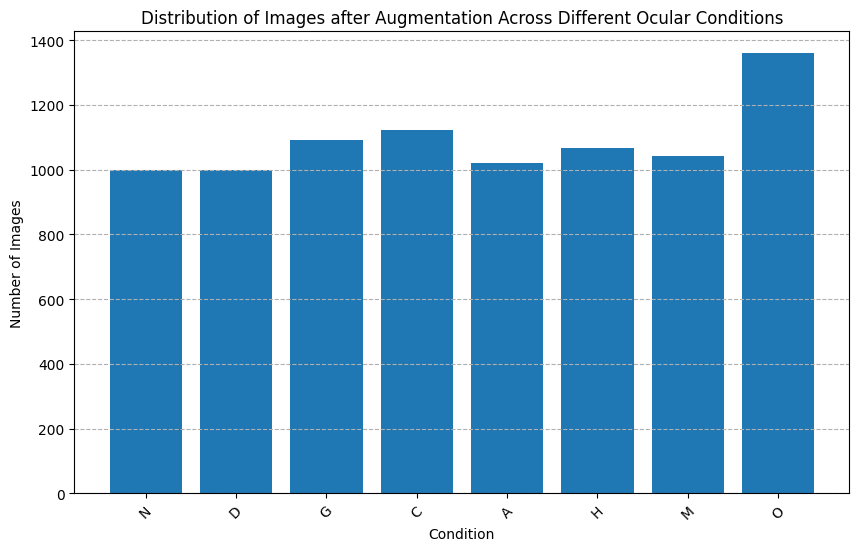

In [ ]:

df_augmented['target'] = df_augmented['target'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


assert all(len(t) == 8 for t in df_augmented['target']), "Not all target lists are of length 8."

class_distribution = np.sum(df_augmented['target'].tolist(), axis=0)
class_labels = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

class_distribution_dict = dict(zip(class_labels, class_distribution))

for label, count in class_distribution_dict.items():
    print(f"Class {label}: {count}")

plt.figure(figsize=(10, 6))
class_distribution_dict = dict(zip(class_labels, class_distribution))
plt.bar(class_distribution_dict.keys(), class_distribution_dict.values())
plt.title('Distribution of Images after Augmentation Across Different Ocular Conditions')
plt.xlabel('Condition')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
